In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

 94% 61.0M/65.2M [00:02<00:00, 38.8MB/s]
100% 65.2M/65.2M [00:02<00:00, 28.2MB/s]


In [ ]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
import os
import cv2 as cv
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras.layers import Conv2D, MaxPooling2D, Input, Dropout, Lambda, Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.applications import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
test_dir = '/content/test'
train_dir = '/content/train'
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

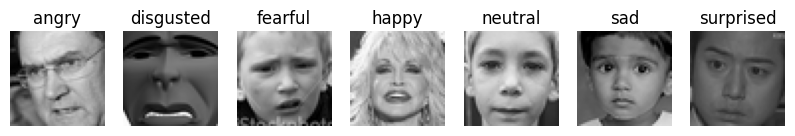

In [ ]:
index = 1
plt.figure(figsize=(10, 5))
for classname in classes:
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir)[:1]:
        image = cv.imread(os.path.join(class_dir, filename))
        
        plt.subplot(1, len(classes), index)
        plt.title(classname)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        
        index += 1
        
plt.show()

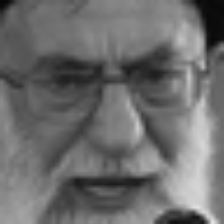

In [ ]:
images = []
image_classes = []
total_image_per_class = []

for classname in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, classname)
    
    for filename in os.listdir(class_dir):
        image = cv.imread(os.path.join(class_dir, filename))
        image = cv.resize(image, (224, 224))
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(image)
        image_classes.append(classname)
        
    total_image_per_class.append(len(os.listdir(class_dir)))
        
data = list(zip(images, image_classes))
len(data)
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=.2)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

In [ ]:
training_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  shuffle=True,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                  subset='training',
                                                  seed=10)

validation_data = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    subset='validation',
                                                    seed=10)

testing_data = test_datagen.flow_from_directory(test_dir,
                                                target_size=(224, 224),
                                                shuffle=False,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                # subset='training',
                                                seed=10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
inception = InceptionV3(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)
inception_model = inception.output
inception_model = Flatten(name="flatten")(inception_model)
inception_model = Dense(512, activation="relu")(inception_model)
inception_model = Dropout(0.5)(inception_model)
inception_model = Dense(7, activation="softmax")(inception_model)
model = Model(inputs=inception.input, outputs=inception_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
for layer in inception.layers:
	layer.trainable = False

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 395s 529ms/step - loss: 1.6402 - accuracy: 0.3760 - val_loss: 1.4660 - val_accuracy: 0.4457
Epoch 2/20
718/718 [==============================] - 360s 501ms/step - loss: 1.4781 - accuracy: 0.4380 - val_loss: 1.4035 - val_accuracy: 0.4705
Epoch 3/20
718/718 [==============================] - 370s 516ms/step - loss: 1.4171 - accuracy: 0.4630 - val_loss: 1.3533 - val_accuracy: 0.4830
Epoch 4/20
718/718 [==============================] - 354s 493ms/step - loss: 1.3870 - accuracy: 0.4784 - val_loss: 1.3389 - val_accuracy: 0.4914
Epoch 5/20
718/718 [==============================] - 360s 502ms/step - loss: 1.3586 - accuracy: 0.4875 - val_loss: 1.3214 - val_accuracy: 0.4997
Epoch 6/20
718/718 [==============================] - 373s 519ms/step - loss: 1.3384 - accuracy: 0.4964 - val_loss: 1.3196 - val_accuracy: 0.5039
Epoch 7/20
718/718 [==============================] - 371s 517ms/step - loss: 1.3194 - accuracy: 0.5070 - val_loss: 1.3028 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

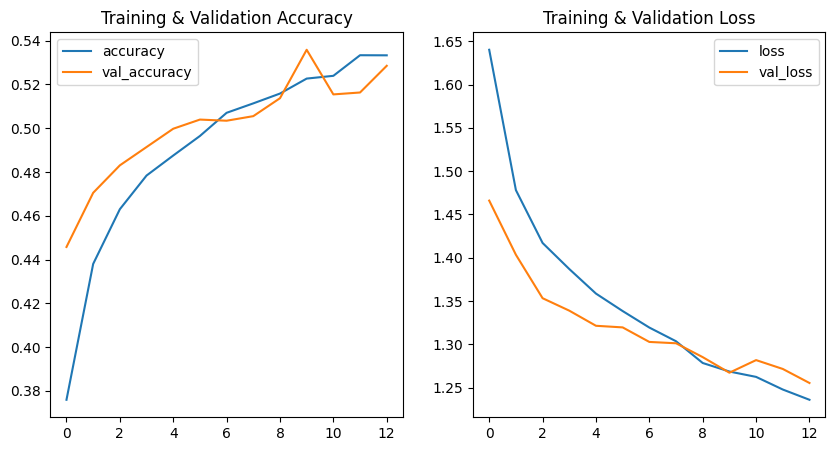

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 92s 404ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.42      0.35      0.38       958
           1       1.00      0.02      0.04       111
           2       0.38      0.26      0.31      1024
           3       0.66      0.78      0.71      1774
           4       0.50      0.51      0.50      1233
           5       0.42      0.48      0.45      1247
           6       0.65      0.67      0.66       831

    accuracy                           0.53      7178
   macro avg       0.58      0.44      0.44      7178
weighted avg       0.52      0.53      0.51      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.5273056561716356
recall:  0.5273056561716356
precision:  0.5221840631749771
f1-score:  0.5136518752852346
Result =  0.5226118127008708


In [ ]:
for layer in inception.layers:
	layer.trainable = True

In [ ]:
optimizer = SGD(learning_rate=1e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=False)

history = model.fit(training_data,
                    epochs=20,
                    validation_data=validation_data,
                    callbacks=[callback])

Epoch 1/20
718/718 [==============================] - 413s 558ms/step - loss: 1.6628 - accuracy: 0.3386 - val_loss: 1.4891 - val_accuracy: 0.4252
Epoch 2/20
718/718 [==============================] - 401s 558ms/step - loss: 1.4626 - accuracy: 0.4365 - val_loss: 1.3919 - val_accuracy: 0.4719
Epoch 3/20
718/718 [==============================] - 402s 560ms/step - loss: 1.3600 - accuracy: 0.4797 - val_loss: 1.2953 - val_accuracy: 0.5067
Epoch 4/20
718/718 [==============================] - 401s 558ms/step - loss: 1.2839 - accuracy: 0.5094 - val_loss: 1.2492 - val_accuracy: 0.5222
Epoch 5/20
718/718 [==============================] - 400s 557ms/step - loss: 1.2272 - accuracy: 0.5307 - val_loss: 1.2166 - val_accuracy: 0.5368
Epoch 6/20
718/718 [==============================] - 397s 554ms/step - loss: 1.1851 - accuracy: 0.5480 - val_loss: 1.2015 - val_accuracy: 0.5490
Epoch 7/20
718/718 [==============================] - 398s 555ms/step - loss: 1.1431 - accuracy: 0.5647 - val_loss: 1.1494 -

In [ ]:
def visualize_history(history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training & Validation Accuracy")
    plt.plot(epochs, accuracy, label="accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Training & Validation Loss")
    plt.plot(epochs, loss, label="loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.legend()

    plt.show()

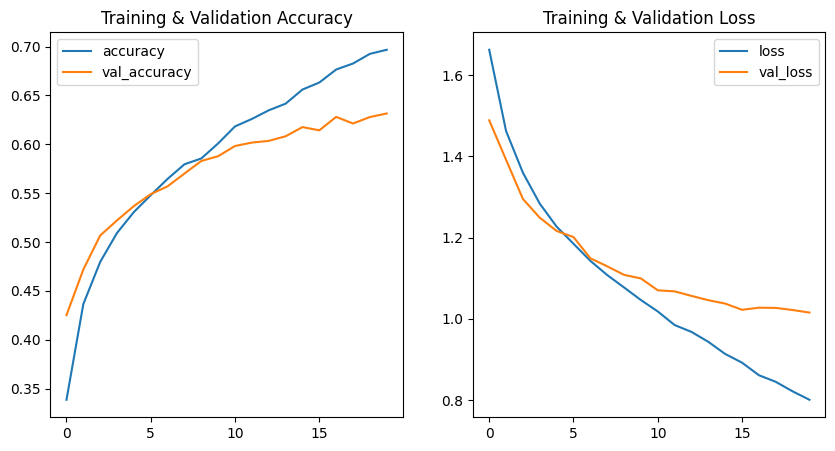

In [ ]:
visualize_history(history)

In [ ]:
y_pred = model.predict(testing_data)
y_pred_labels = []
for i in y_pred:
    y_pred_labels.append(np.argmax(i))
y_actual = testing_data.classes[testing_data.index_array]

225/225 [==============================] - 92s 411ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred_labels))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       958
           1       0.77      0.33      0.47       111
           2       0.52      0.35      0.42      1024
           3       0.85      0.84      0.84      1774
           4       0.60      0.59      0.59      1233
           5       0.45      0.61      0.51      1247
           6       0.76      0.76      0.76       831

    accuracy                           0.63      7178
   macro avg       0.64      0.57      0.59      7178
weighted avg       0.64      0.63      0.63      7178



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

acc = accuracy_score(y_actual, y_pred_labels)
prec = precision_score(y_actual, y_pred_labels, average='weighted')
rec = recall_score(y_actual, y_pred_labels, average='weighted')
f1 = f1_score(y_actual, y_pred_labels, average='weighted')

print("accuracy: ", acc)
print("recall: ", rec)
print("precision: ", prec)
print("f1-score: ", f1)
print("Result = ", (acc+rec+prec+f1)/4)

accuracy:  0.628169406519922
recall:  0.628169406519922
precision:  0.6358623550536109
f1-score:  0.6262451215402134
Result =  0.629611572408417
